In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go

import sys; sys.path.append('../src/')
import one_dim_search.dichotomy as dichot
import one_dim_search.fib as fib
import one_dim_search.linear as lin
import one_dim_search.golden as gold
from descent.grad import gradient_descent_iter, get_constant_step_chooser

from IPython.display import Image

In [2]:
def gen1(cond, n):
    r = math.sqrt(cond)
    A = np.random.randn(n, n)
    u, s, v = np.linalg.svd(A)
    h, l = np.max(s), np.min(s)

    def f(x):
        return h * (1 - ((r - 1) / r) / (h - l) * (h - x))

    new_s = f(s)
    new_A = (u * new_s) @ v.T
    new_A = new_A @ new_A.T
    return new_A

def gen2(cond, n):
    min_v = 1
    max_v = cond
    assert max_v / min_v == cond
    diag = [min_v, max_v]
    while len(diag) < n:
        diag.append(random.uniform(min_v, max_v))
        
    return np.diag(diag)
#     f = lambda diag.dot(x ** 2) - b.dot(x)
#     f_grad = lambda x: 2 * diag * x - b
    

def generate_func(cond, n, matrix_gen=gen1):
    b = np.random.randn(n)
    A = matrix_gen(cond, n)
    f = lambda x: x.dot(A).dot(x) - b.dot(x)
    f_grad = lambda x: (A + A.T).dot(x) - b

    
    return f, f_grad, A

In [3]:
def analyze(step_chooser, eps=1e-3, repeat_cnt=10, matrix_gen=gen1):
    data = []
    for cond in tqdm(np.linspace(1, 1000, 20)):
        for n in [5, 10, 20, 50, 100]:
            cnts = []
            for _ in range(repeat_cnt):
                f, f_grad, _ = generate_func(cond=cond, n=n, matrix_gen=matrix_gen)
                it = gradient_descent_iter(
                    f=f, f_grad=f_grad, eps=eps,
                    start=np.random.randn(n),
                    step_chooser=step_chooser,
                    _verbose=100000,
                    stop_criterion='value'
                )
                cnts.append(sum(1 for _ in it))
            data.append({'cond': cond, 'n': n,
                         'cnt': sum(cnt for cnt in cnts)/repeat_cnt})
    fig = px.line(data, x='cond', y='cnt', color='n', log_y=True)
    fig.show()

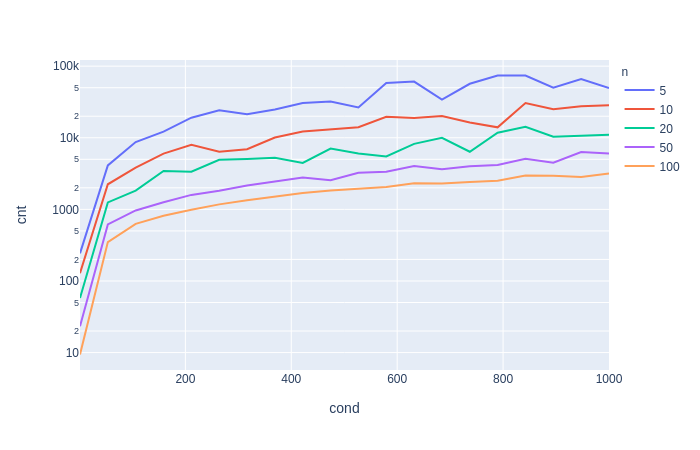

In [10]:
# analyze(get_constant_step_chooser(1e-3), eps=1e-5)
Image('pics/condition_number1.png')

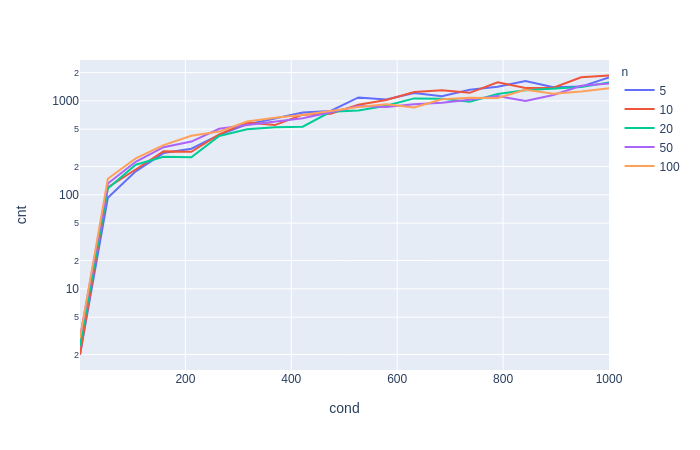

In [11]:
def generic_step_chooser(one_dim_search):
    def step_chooser(f, x_k, cur_grad):
        phi = lambda h: f(x_k - h * cur_grad)
        l, r = lin.search(0, delta=1e-5, f=phi, eps=1e-5, multiplier=2)
        l, r = one_dim_search(l, r, f=phi, eps=1e-5)
        return (l + r) / 2
    return step_chooser

# analyze(generic_step_chooser(gold.search), eps=1e-5)
Image('pics/condition_number2.png')

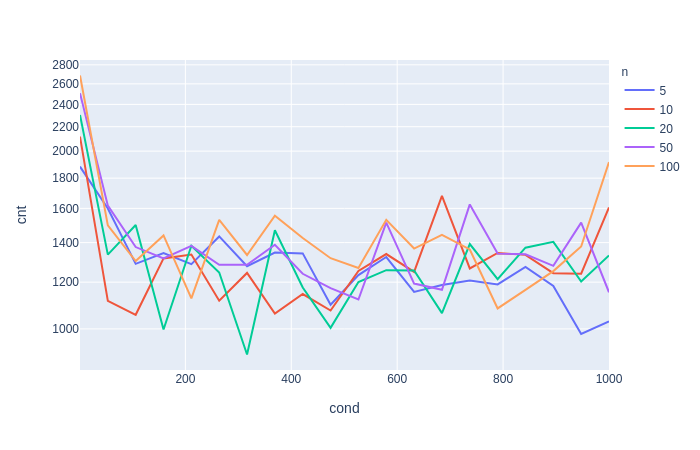

In [12]:
# analyze(get_constant_step_chooser(1e-3), eps=1e-5, matrix_gen=gen2)
Image('pics/condition_number3.png')

In [7]:
def analyze2(step_chooser, eps=1e-3, repeat_cnt=10, matrix_gen=gen1):
    data = []
    for cond in tqdm(np.linspace(0.5, 1, 20)):
        for n in [5, 10, 20, 50, 100]:
            cnts = []
            for _ in range(repeat_cnt):
                f, f_grad, _ = generate_func(cond=cond, n=n, matrix_gen=matrix_gen)
                it = gradient_descent_iter(
                    f=f, f_grad=f_grad, eps=eps,
                    start=np.random.randn(n),
                    step_chooser=step_chooser,
                    _verbose=100000,
                    stop_criterion='value'
                )
                cnts.append(sum(1 for _ in it))
            data.append({'cond': cond, 'n': n,
                         'cnt': sum(cnt for cnt in cnts)/repeat_cnt})
    fig = px.line(data, x='cond', y='cnt', color='n', log_y=True)
    fig.show()

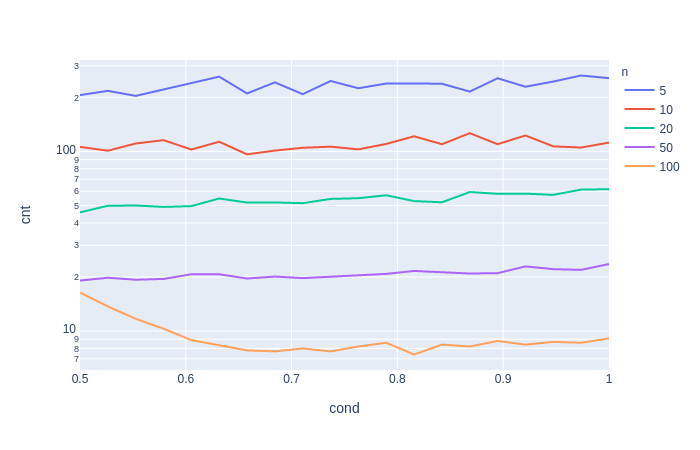

In [13]:
# analyze2(get_constant_step_chooser(1e-3), eps=1e-5)
Image('pics/condition_number4.png')